# LikesLearning

## Applying Cognitive Services and Machine Learning to Discover Photo Likability on Instagram

You may have wondered - what makes a good Instagram photo, which recives big number of likes from you followers? In this demo, we will try to answer this question using Data Science!

I will take my own Instagram ([@shwars](http://instagram.com/shwars)) as an example, and I encourage you to do the same with yours. You are likely to get slightly different results, because subscribed audiences differ, and some of the findings might surprise you!

So, what I have done prior to this demo:

1. Download all your content from Instagram. You may find instructions [here](https://www.cnet.com/how-to/how-to-download-all-your-instagram-data/#:~:text=It%27s%20easy%20to%20download%20all,data%20using%20the%20web%20version.&text=Go%20to%20instagram.com.,Scroll%20down%20to%20Data%20Download.)
1. Because Instagram does not provide number of likes for each photo, you may need either to write scraping code to get that from the web, or manually collect number of likes. I did the latter.
1. At the end, I came up with the dataset, which consists of the following:
   - [JSON file](data/instagram_shwars.jsondata/instagram_shwars.json) with all the metadata
   - Actual pictures uploaded to the Azure Blob Storage, which are available at the URL specified by `photo_storage`:

In [5]:
json_file = 'data/instagram_shwars.json'
photo_storage = "https://instagramdataset.blob.core.windows.net/shwars/"

Let's start by importing some of the required libraries.

In [55]:
import sys, os
import json
import pandas as pd
import matplotlib.pyplot as plt
import functools

Now let's load JSON file and see how it looks like:

In [7]:
with open(json_file, encoding='utf-8') as f:
    data = json.load(f)

In [8]:
data[0]

{'taken_at': '2020-07-01 10:56:38+00:00',
 'caption': 'Всем привет! За несколько месяцев вынужденной изоляции существенно возросло количество фотографий еды в моём телефоне. Чтобы не утомлять своих подписчиков большим количеством еды, и при этом не испытывать муки совести от того, что публикую не слишком интересный контент, я решил использовать для еды отдельный аккаунт @how.tasty. Подписывайтесь, если хотите поднимать аппетит фотографиями аппетитных блюд, иногда с рецептами...\n#food #foodporn #foodphotography #cooking #amateurchef #foodphoto #foodie',
 'path': ['202007_b183670c4a31d853441d05d9e2600828.jpg'],
 'likes': '20'}

To make it easier to work with this file, we will convert it to Pandas Dataframe, and also take care of some of the data conversion:

In [10]:
df = pd.DataFrame(data)
df['taken_at'] = pd.to_datetime(df['taken_at'],errors='raise')
start_date = df['taken_at'].min()
df['days'] = df['taken_at'].apply(lambda x: (x-start_date).days)
df['likes'] = df['likes'].astype(int)
df.dtypes

taken_at    datetime64[ns, UTC]
caption                  object
path                     object
likes                     int32
days                      int64
dtype: object

In [35]:
df

,taken_at,caption,path,likes,days,tags
0,2020-07-01 10:56:38+00:00,Всем привет! За несколько месяцев вынужденной ...,[202007_b183670c4a31d853441d05d9e2600828.jpg],20,905,"[#food, #foodporn, #foodphotography, #cooking,..."
1,2020-06-27 19:52:12+00:00,Закаты самоизоляции...\n#sunset #sunsetporn,"[202006_5476cbb7f7840f22edde32a8f5d070b7.jpg, ...",69,902,"[#sunset, #sunsetporn]"
2,2020-06-20 16:27:44+00:00,"Соленый зерненый творог с чесноком, топленой с...","[202006_0d6ed4957cab4e711971966fb76326a5.jpg, ...",27,895,[]
3,2020-06-18 23:17:54+00:00,Сегодня на ужин - лазанья от @elementaree.ru. ...,"[202006_6aefd795ffa24f8acabc753be509035b.jpg, ...",39,893,[]
4,2020-06-12 15:04:11+00:00,Знатокам английского! Если черешня - это sweet...,[202006_eff303af9c9bcf5e3893f09e1b1edbfd.jpg],35,887,[]
...,...,...,...,...,...,...
1035,2018-01-09 05:40:38+00:00,В раздевалке...,[201801_84788221c4213fb032f9076162be4ad5.jpg],46,1,[]
1036,2018-01-08 23:33:10+00:00,Геометрия сосисочного шашлыка в детском лагере...,[201801_ccc3144c9aeb304eddf4810318c61390.jpg],33,1,"[#junio-r, #bestcamp, #geometryof]"
1037,2018-01-07 21:35:26+00:00,Компьютерный класс готовится принять детей - а...,[201801_f499543f9e3379a0a0ca44527ce27709.jpg],33,0,[#minecraftedu]
1038,2018-01-07 21:32:58+00:00,"Зимняя #компьютерия, или немного предзакатного...",[201801_42cb11c0fc018a768cfccbfa036c0a2d.jpg],47,0,"[#компьютерия,]"


## Exploring the Data

Now that we have the data - let's start exploring! First of all, let's just plot the number of likes:

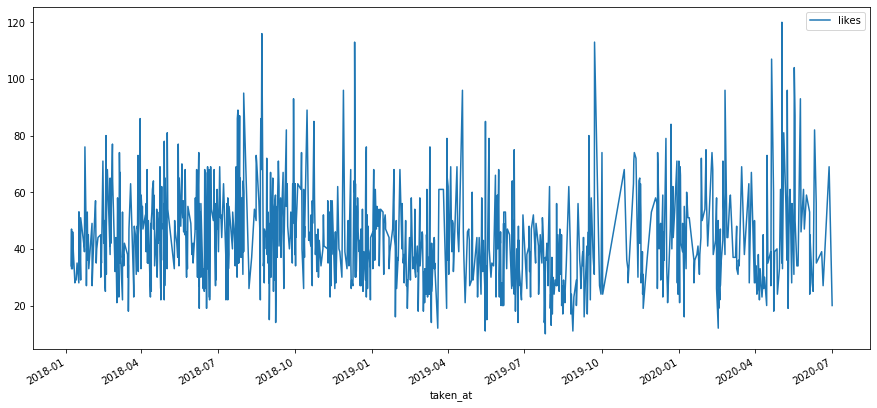

In [13]:
df.plot('taken_at','likes',figsize=(15,7))

From this plot, it is not very obvious how the number of likes changes with time. To make it easier to grasp, we can compute the running average over this data - let's say, with the window of 10,20,30 and 60 posts:

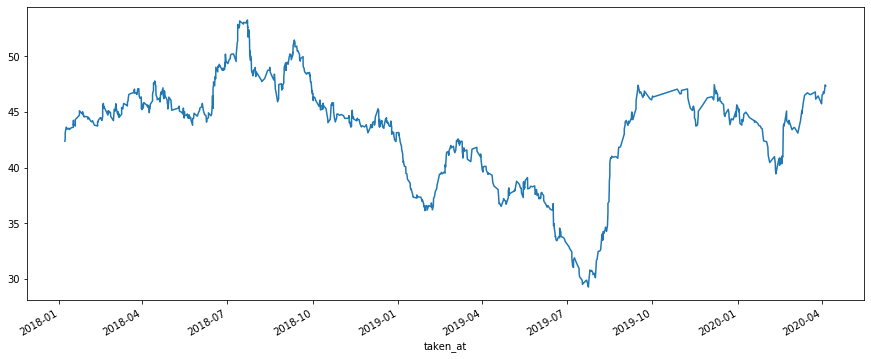

In [30]:
df.set_index('taken_at')['likes'].rolling(window=60).mean().plot(figsize=(15,6))

It would also be interesting to have a look at the average number of likes by month:

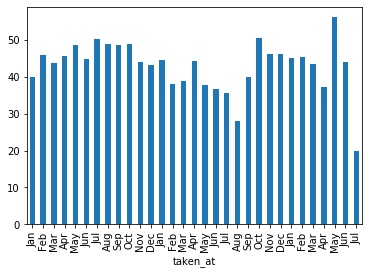

In [31]:
dff = df.set_index('taken_at').groupby(pd.Grouper(freq='M'))['likes'].mean()
ax = dff.plot(kind='bar')
x_labels = dff.index.strftime('%b')
ax.set_xticklabels(x_labels)
plt.show()

Another dependency we may want to explore is how likes depend on the number of pictures in the post.

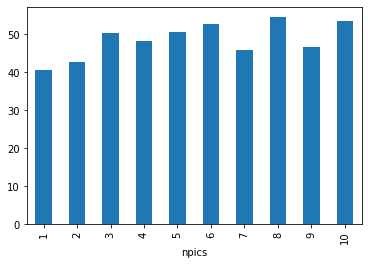

In [41]:
df['npics'] = df['path'].apply(len)
df.groupby('npics')['likes'].mean().plot(kind='bar')

## Learning with Tags

It would be logical to assume that tags affect photo likability. To discover that, let's extract tags from description using regular expressions:

In [32]:
df['tags'] = df['caption'].str.findall(r'#.*?(?=\s|$)')
df

,taken_at,caption,path,likes,days,tags
0,2020-07-01 10:56:38+00:00,Всем привет! За несколько месяцев вынужденной ...,[202007_b183670c4a31d853441d05d9e2600828.jpg],20,905,"[#food, #foodporn, #foodphotography, #cooking,..."
1,2020-06-27 19:52:12+00:00,Закаты самоизоляции...\n#sunset #sunsetporn,"[202006_5476cbb7f7840f22edde32a8f5d070b7.jpg, ...",69,902,"[#sunset, #sunsetporn]"
2,2020-06-20 16:27:44+00:00,"Соленый зерненый творог с чесноком, топленой с...","[202006_0d6ed4957cab4e711971966fb76326a5.jpg, ...",27,895,[]
3,2020-06-18 23:17:54+00:00,Сегодня на ужин - лазанья от @elementaree.ru. ...,"[202006_6aefd795ffa24f8acabc753be509035b.jpg, ...",39,893,[]
4,2020-06-12 15:04:11+00:00,Знатокам английского! Если черешня - это sweet...,[202006_eff303af9c9bcf5e3893f09e1b1edbfd.jpg],35,887,[]
...,...,...,...,...,...,...
1035,2018-01-09 05:40:38+00:00,В раздевалке...,[201801_84788221c4213fb032f9076162be4ad5.jpg],46,1,[]
1036,2018-01-08 23:33:10+00:00,Геометрия сосисочного шашлыка в детском лагере...,[201801_ccc3144c9aeb304eddf4810318c61390.jpg],33,1,"[#junio-r, #bestcamp, #geometryof]"
1037,2018-01-07 21:35:26+00:00,Компьютерный класс готовится принять детей - а...,[201801_f499543f9e3379a0a0ca44527ce27709.jpg],33,0,[#minecraftedu]
1038,2018-01-07 21:32:58+00:00,"Зимняя #компьютерия, или немного предзакатного...",[201801_42cb11c0fc018a768cfccbfa036c0a2d.jpg],47,0,"[#компьютерия,]"


The most obvious dependency is on the number of likes. We would assume that if a picture has more tags - it probably has move likes, because additional audience is attracted to it.

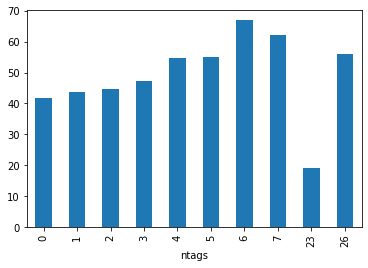

In [98]:
df['ntags'] = df['tags'].apply(len)
df.groupby('ntags')['likes'].mean().plot(kind='bar')

Now let's discover most frequent tags and analyze their performance individually. To do that, we will compute average # of likes for pictures that contain different tags:

In [33]:
def freq(l,threshold=0):
    d = {}
    for x in l:
        d[x] = d.get(x,0)+1
    return { k:v for k,v in d.items() if v>threshold }

freq(df['tags'].sum(),10)

{'#sunset': 17,
 '#geometryof': 191,
 '#quarantine': 15,
 '#quarantinelife': 12,
 '#urbansunset': 12,
 '#будниевангелиста': 78,
 '#shwarsustrip': 15,
 '#imaginecup': 14,
 '#imcup': 13}

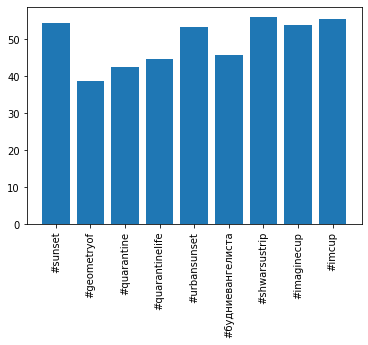

In [34]:
tags = freq(df['tags'].sum(),10).keys()
tag_likes = [df[df['tags'].apply(lambda x: t in x)]['likes'].mean() for t in tags]
plt.bar(x=tags,height=tag_likes)
plt.xticks(rotation=90)
plt.show()

## Analyzing Contents of Pictures

Instagram is all about visual content, and people like pictures because they find them visually appealling. Let's try to extract some meaningful features from pictures by analyzing them using [Cognitive Services Computer Vision API](https://docs.microsoft.com/azure/cognitive-services/computer-vision/?WT.mc_id=ca-6956-dmitryso)

First, we need to make sure that Python Computer Vision SDK is installed. If you want to read more docs on Computer Vision - [here they are](https://docs.microsoft.com/azure/cognitive-services/computer-vision/quickstarts-sdk/client-library?pivots=programming-language-python&WT.mc_id=ca-6956-dmitryso)

In [42]:
!{sys.executable} -m pip install azure-cognitiveservices-vision-computervision

To make Computer Vision calls, we need **key** and **endpoint URL**. They can be obtained in one of the following ways:
* If you have an Azure Subscription, [create Computer Vision resource](https://portal.azure.com/#create/Microsoft.CognitiveServicesComputerVisionhttps://portal.azure.com/#create/Microsoft.CognitiveServicesComputerVision) and take values from there
* If you do not have a subscription - get [free trial](https://azure.microsoft.com/free/?WT.mc_id=ca-6956-dmitryso), or [free student trial](https://azure.microsoft.com/en-us/free/students/?WT.mc_id=ca-6956-dmitryso)
* If you just want to try things once - [get trial key here](https://azure.microsoft.com/try/cognitive-services/my-apis/?api=computer-vision&WT.mc_id=ca-6956-dmitryso) (which is valid for a week) 

Once you get that data - create a file called `keys.json` in the current directory, putting your data there. You can use the following cell as an example, or copy provided `keys_sample.json`.

In [58]:
%%writefile keys.json
{
    "endpoint": "https://--region--.api.cognitive.microsoft.com/",
    "key": "---your key here---"
}

Writing keys1.json


In [59]:
with open('keys.json','r') as f:
    keys = json.load(f)

Data from photographs can be analyzed with just one call to the `ComputerVisionClient` object, which we create here:

In [62]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials

credentials = CognitiveServicesCredentials(keys['key'])
client = ComputerVisionClient(
    endpoint=keys['endpoint'],
    credentials=credentials
)

client.analyze_image('https://soshnikov.com/images/official/shwars_casual.jpg',visual_features=[VisualFeatureTypes.faces]).as_dict()

{'faces': [{'age': 42,
   'gender': 'Male',
   'face_rectangle': {'left': 483, 'top': 234, 'width': 298, 'height': 298}}],
 'request_id': 'cf77a04d-4adb-4343-8f56-f6ade8c3d2bb',
 'metadata': {'width': 1271, 'height': 847, 'format': 'Jpeg'}}

In [46]:
def analyze(fn):
    return client.analyze_image(photo_storage + fn,visual_features=
      [VisualFeatureTypes.categories, VisualFeatureTypes.faces,
       VisualFeatureTypes.tags, VisualFeatureTypes.color, VisualFeatureTypes.adult,
       VisualFeatureTypes.description, VisualFeatureTypes.objects]).as_dict()

analyze(data[4]['path'][0])

{'categories': [{'name': 'people_portrait',
   'score': 0.64453125,
   'detail': {'celebrities': [{'name': 'Dmitri Soshnikov',
      'confidence': 0.9986395239830017,
      'face_rectangle': {'left': 410,
       'top': 593,
       'width': 408,
       'height': 408}}]}}],
 'adult': {'is_adult_content': True,
  'is_racy_content': True,
  'is_gory_content': False,
  'adult_score': 0.8249362111091614,
  'racy_score': 0.8336015343666077,
  'gore_score': 0.04116944968700409},
 'color': {'dominant_color_foreground': 'Brown',
  'dominant_color_background': 'Brown',
  'dominant_colors': ['Brown', 'Black', 'White'],
  'accent_color': '7E754D',
  'is_bw_img': False},
 'tags': [{'name': 'person', 'confidence': 0.9993911981582642},
  {'name': 'man', 'confidence': 0.998226523399353},
  {'name': 'indoor', 'confidence': 0.945901095867157},
  {'name': 'human face', 'confidence': 0.9311392307281494},
  {'name': 'selfie', 'confidence': 0.906960129737854},
  {'name': 'human beard', 'confidence': 0.863548

Now we need to analyze all photographs in our dataset! There are a few problems which we may face:
* Some pictures are videos, which are not present in the dataset. We need to make sure that if image is not found - it is just skipped. We implement `safe_map` function, similar to `map`, but ignoring errors.
* Free tier of Computer Vision allows only 20 calls per minute. If you are on the free tier, and want to analyze all pictures - insert a delay into `analyze` function, and keep the process running overnight.

In [53]:
def safe_map(seq,f):
    for x in seq:
        try:
            yield f(x)
        except Exception as e:
            print(" - Error: {}".format(e))

def safe_mapl(seq,f):
    return list(safe_map(seq,f))

df['cognitive'] = df['path'].apply(functools.partial(safe_mapl,f=analyze))
df.head()

- Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not accessible.
 - Error: Image URL is not

,taken_at,caption,path,likes,days,tags,npics,cognitive
0,2020-07-01 10:56:38+00:00,Всем привет! За несколько месяцев вынужденной ...,[202007_b183670c4a31d853441d05d9e2600828.jpg],20,905,"[#food, #foodporn, #foodphotography, #cooking,...",1,"[{'categories': [{'name': 'people_', 'score': ..."
1,2020-06-27 19:52:12+00:00,Закаты самоизоляции...\n#sunset #sunsetporn,"[202006_5476cbb7f7840f22edde32a8f5d070b7.jpg, ...",69,902,"[#sunset, #sunsetporn]",3,"[{'categories': [{'name': 'sky_cloud', 'score'..."
2,2020-06-20 16:27:44+00:00,"Соленый зерненый творог с чесноком, топленой с...","[202006_0d6ed4957cab4e711971966fb76326a5.jpg, ...",27,895,[],2,"[{'categories': [{'name': 'drink_', 'score': 0..."
3,2020-06-18 23:17:54+00:00,Сегодня на ужин - лазанья от @elementaree.ru. ...,"[202006_6aefd795ffa24f8acabc753be509035b.jpg, ...",39,893,[],5,"[{'categories': [{'name': 'food_', 'score': 0...."
4,2020-06-12 15:04:11+00:00,Знатокам английского! Если черешня - это sweet...,[202006_eff303af9c9bcf5e3893f09e1b1edbfd.jpg],35,887,[],1,"[{'categories': [{'name': 'people_portrait', '..."


Once we have the data - we save the file into pickled version, so that we do not have to go through the same process again.

In [56]:
os.makedirs('temp',exist_ok=True)
df.to_pickle('temp/data.pkl')

In [63]:
df = pd.read_pickle('temp/data.pkl')

Now let's extract some useful features from the JSON data. We have either one, or a set of pictures corresponding to each post, so we need to aggregate accross several pictures sometimes. This can be done is multiple ways, here is what we will extract:
* Average age of all faces on all pictures
* Average gender (considering 1 for male, -1 for female).
* Presence of male and female pictures


In [94]:
def mean(l):
    if len(l)==0:
        return 0
    else:
        return sum(l)/len(l)

def process_result(ar):
    faces = sum([x['faces'] for x in ar],[])
    categs = sum([x['categories'] for x in ar],[])
    categs.sort(key=lambda x: x['score'],reverse=True) 
    tags = sum([x['tags'] for x in ar],[])
    age_list = [1 if x['gender']=='Male' else -1 for x in faces]
    safe = lambda z: "" if len(z)==0 else z[0]['text']
    return {
        "category" : categs[0]['name'] if len(categs)>0 else "",
        "categories" : set(x['name'] for x in categs),
        "nfaces" : len(faces),
        "age" : mean([x['age'] for x in faces]),
        "gender" : mean(age_list),
        "vtags" : set(x['name'] for x in tags),
        "description" : ".".join([safe(x['description']['captions']) for x in ar]),
        "adult_score" : mean([x['adult']['adult_score'] for x in ar])
    }

process_result(df['cognitive'][4])

{'category': 'people_portrait',
 'categories': {'people_portrait'},
 'nfaces': 1,
 'age': 45.0,
 'gender': 1.0,
 'vtags': {'beard',
  'clothing',
  'human beard',
  'human face',
  'indoor',
  'man',
  'moustache',
  'person',
  'selfie'},
 'description': 'Dmitri Soshnikov looking at the camera',
 'adult_score': 0.8249362111091614}

Now let's add all the processing results into the same frame:

In [96]:
df = df.join(df['cognitive'].apply(lambda x: pd.Series(process_result(x))))

In [98]:
df.iloc[0]

taken_at                               2020-07-01 10:56:38+00:00
caption        Всем привет! За несколько месяцев вынужденной ...
path               [202007_b183670c4a31d853441d05d9e2600828.jpg]
likes                                                         20
days                                                         905
tags           [#food, #foodporn, #foodphotography, #cooking,...
npics                                                          1
cognitive      [{'categories': [{'name': 'people_', 'score': ...
category                                                 people_
categories                                             {people_}
nfaces                                                         0
age                                                            0
gender                                                         0
vtags          {person, indoor, food, delicious, baked goods,...
description                     a person holding a piece of cake
adult_score              